In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline



In [2]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
import os

In [3]:
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

In [4]:
RANDOM_SEED = 123
BATCH_SIZE = 32
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LR = 0.1
NUM_ATTRIBUTE = 13
NUM_HIDDEN_1 = 1024
NUM_HIDDEN_2 = 1024
NUM_CLASS = 6
OUTCOME = 'popularity'

In [5]:
set_all_seeds(RANDOM_SEED)
set_deterministic()

# Load Data

In [6]:
class MyDataset(Dataset):

    def __init__(self, csv_path):
    
        df = pd.read_csv(csv_path)
        
        self.x = torch.tensor(df.iloc[:, :NUM_ATTRIBUTE].values).float()
        self.y = torch.tensor(df[OUTCOME].values).long()
        
        mean = torch.mean(self.x, dim=0)
        std = torch.std(self.x, dim=0)
        self.x = (self.x - mean)/std
        #print(len(self.x))
        #print(len(self.y))

    def __getitem__(self, index):
        attributes = self.x[index]
        label = self.y[index]
        return attributes, label

    def __len__(self):
        return self.y.shape[0]

In [8]:

train_dataset = MyDataset(csv_path='class_data/popularity_spotify_train.csv')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use

valid_dataset = MyDataset(csv_path='class_data/popularity_spotify_valid.csv')

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0)



test_dataset = MyDataset(csv_path='class_data/popularity_spotify_test.csv')

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)

In [9]:
for attributes, labels in train_loader:  
    print('Image batch dimensions:', attributes.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 13])
Image label dimensions: torch.Size([32])


# ONE-HOT CODE

In [10]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    tmp = y.view(-1, 1).long().to(torch.device('cpu'))
    y_onehot.scatter_(1, tmp, 1).float()
    return y_onehot

# Model

In [11]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, drop_proba, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        self.my_network = torch.nn.Sequential(
            ### 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.Dropout(drop_proba),
            ### 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.Dropout(drop_proba),
            ### Output layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )
        
        '''
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### 1st hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()

        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        '''
        
    def forward(self, x):
        logits = self.my_network(x)
        return logits
        '''
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        logits = self.linear_out(out)
        #probas = F.log_softmax(logits, dim=1)
        return logits#, probas
        '''

## Model Initialization with BatchNorm

Epoch: 001/100 | Batch 0000/0820 | Loss: 1.9976
Epoch: 001/100 | Batch 0050/0820 | Loss: 5.6630
Epoch: 001/100 | Batch 0100/0820 | Loss: 5.2557
Epoch: 001/100 | Batch 0150/0820 | Loss: 4.1299
Epoch: 001/100 | Batch 0200/0820 | Loss: 4.7228
Epoch: 001/100 | Batch 0250/0820 | Loss: 3.8540
Epoch: 001/100 | Batch 0300/0820 | Loss: 3.2972
Epoch: 001/100 | Batch 0350/0820 | Loss: 5.0835
Epoch: 001/100 | Batch 0400/0820 | Loss: 4.6720
Epoch: 001/100 | Batch 0450/0820 | Loss: 3.3325
Epoch: 001/100 | Batch 0500/0820 | Loss: 3.1037
Epoch: 001/100 | Batch 0550/0820 | Loss: 3.6000
Epoch: 001/100 | Batch 0600/0820 | Loss: 4.2534
Epoch: 001/100 | Batch 0650/0820 | Loss: 2.2321
Epoch: 001/100 | Batch 0700/0820 | Loss: 4.4629
Epoch: 001/100 | Batch 0750/0820 | Loss: 2.6244
Epoch: 001/100 | Batch 0800/0820 | Loss: 3.2784
Epoch: 001/100 | Train: 27.13% | Validation: 26.55%
Time elapsed: 0.05 min
Epoch: 002/100 | Batch 0000/0820 | Loss: 2.7007
Epoch: 002/100 | Batch 0050/0820 | Loss: 3.3420
Epoch: 002/10

Epoch: 010/100 | Batch 0200/0820 | Loss: 1.4208
Epoch: 010/100 | Batch 0250/0820 | Loss: 1.5350
Epoch: 010/100 | Batch 0300/0820 | Loss: 1.3020
Epoch: 010/100 | Batch 0350/0820 | Loss: 1.4921
Epoch: 010/100 | Batch 0400/0820 | Loss: 1.3721
Epoch: 010/100 | Batch 0450/0820 | Loss: 1.5251
Epoch: 010/100 | Batch 0500/0820 | Loss: 1.5028
Epoch: 010/100 | Batch 0550/0820 | Loss: 1.4825
Epoch: 010/100 | Batch 0600/0820 | Loss: 1.4202
Epoch: 010/100 | Batch 0650/0820 | Loss: 1.3577
Epoch: 010/100 | Batch 0700/0820 | Loss: 1.3833
Epoch: 010/100 | Batch 0750/0820 | Loss: 1.4935
Epoch: 010/100 | Batch 0800/0820 | Loss: 1.3037
Epoch: 010/100 | Train: 34.99% | Validation: 34.29%
Time elapsed: 0.49 min
Epoch: 011/100 | Batch 0000/0820 | Loss: 1.4340
Epoch: 011/100 | Batch 0050/0820 | Loss: 1.4333
Epoch: 011/100 | Batch 0100/0820 | Loss: 1.5096
Epoch: 011/100 | Batch 0150/0820 | Loss: 1.4276
Epoch: 011/100 | Batch 0200/0820 | Loss: 1.3457
Epoch: 011/100 | Batch 0250/0820 | Loss: 1.4378
Epoch: 011/10

Epoch: 019/100 | Batch 0400/0820 | Loss: 1.3890
Epoch: 019/100 | Batch 0450/0820 | Loss: 1.3837
Epoch: 019/100 | Batch 0500/0820 | Loss: 1.4376
Epoch: 019/100 | Batch 0550/0820 | Loss: 1.4221
Epoch: 019/100 | Batch 0600/0820 | Loss: 1.5789
Epoch: 019/100 | Batch 0650/0820 | Loss: 1.3877
Epoch: 019/100 | Batch 0700/0820 | Loss: 1.3792
Epoch: 019/100 | Batch 0750/0820 | Loss: 1.3380
Epoch: 019/100 | Batch 0800/0820 | Loss: 1.4124
Epoch: 019/100 | Train: 35.65% | Validation: 34.17%
Time elapsed: 0.94 min
Epoch: 020/100 | Batch 0000/0820 | Loss: 1.2447
Epoch: 020/100 | Batch 0050/0820 | Loss: 1.3619
Epoch: 020/100 | Batch 0100/0820 | Loss: 1.3903
Epoch: 020/100 | Batch 0150/0820 | Loss: 1.6354
Epoch: 020/100 | Batch 0200/0820 | Loss: 1.6038
Epoch: 020/100 | Batch 0250/0820 | Loss: 1.4479
Epoch: 020/100 | Batch 0300/0820 | Loss: 1.4628
Epoch: 020/100 | Batch 0350/0820 | Loss: 1.4037
Epoch: 020/100 | Batch 0400/0820 | Loss: 1.2150
Epoch: 020/100 | Batch 0450/0820 | Loss: 1.3113
Epoch: 020/10

Epoch: 028/100 | Batch 0600/0820 | Loss: 1.4411
Epoch: 028/100 | Batch 0650/0820 | Loss: 1.4224
Epoch: 028/100 | Batch 0700/0820 | Loss: 1.4126
Epoch: 028/100 | Batch 0750/0820 | Loss: 1.4523
Epoch: 028/100 | Batch 0800/0820 | Loss: 1.3467
Epoch: 028/100 | Train: 36.02% | Validation: 33.98%
Time elapsed: 1.42 min
Epoch: 029/100 | Batch 0000/0820 | Loss: 1.3094
Epoch: 029/100 | Batch 0050/0820 | Loss: 1.4590
Epoch: 029/100 | Batch 0100/0820 | Loss: 1.4836
Epoch: 029/100 | Batch 0150/0820 | Loss: 1.3493
Epoch: 029/100 | Batch 0200/0820 | Loss: 1.3817
Epoch: 029/100 | Batch 0250/0820 | Loss: 1.3306
Epoch: 029/100 | Batch 0300/0820 | Loss: 1.2903
Epoch: 029/100 | Batch 0350/0820 | Loss: 1.4989
Epoch: 029/100 | Batch 0400/0820 | Loss: 1.2333
Epoch: 029/100 | Batch 0450/0820 | Loss: 1.3569
Epoch: 029/100 | Batch 0500/0820 | Loss: 1.4475
Epoch: 029/100 | Batch 0550/0820 | Loss: 1.5095
Epoch: 029/100 | Batch 0600/0820 | Loss: 1.4449
Epoch: 029/100 | Batch 0650/0820 | Loss: 1.5388
Epoch: 029/10

Epoch: 037/100 | Batch 0800/0820 | Loss: 1.5100
Epoch: 037/100 | Train: 35.99% | Validation: 33.92%
Time elapsed: 1.92 min
Epoch: 038/100 | Batch 0000/0820 | Loss: 1.4936
Epoch: 038/100 | Batch 0050/0820 | Loss: 1.3587
Epoch: 038/100 | Batch 0100/0820 | Loss: 1.4486
Epoch: 038/100 | Batch 0150/0820 | Loss: 1.3969
Epoch: 038/100 | Batch 0200/0820 | Loss: 1.3502
Epoch: 038/100 | Batch 0250/0820 | Loss: 1.5723
Epoch: 038/100 | Batch 0300/0820 | Loss: 1.4091
Epoch: 038/100 | Batch 0350/0820 | Loss: 1.3625
Epoch: 038/100 | Batch 0400/0820 | Loss: 1.3586
Epoch: 038/100 | Batch 0450/0820 | Loss: 1.4392
Epoch: 038/100 | Batch 0500/0820 | Loss: 1.4273
Epoch: 038/100 | Batch 0550/0820 | Loss: 1.3843
Epoch: 038/100 | Batch 0600/0820 | Loss: 1.3674
Epoch: 038/100 | Batch 0650/0820 | Loss: 1.3946
Epoch: 038/100 | Batch 0700/0820 | Loss: 1.3159
Epoch: 038/100 | Batch 0750/0820 | Loss: 1.3440
Epoch: 038/100 | Batch 0800/0820 | Loss: 1.4866
Epoch: 038/100 | Train: 36.11% | Validation: 35.75%
Time elap

Epoch: 047/100 | Batch 0100/0820 | Loss: 1.4263
Epoch: 047/100 | Batch 0150/0820 | Loss: 1.4086
Epoch: 047/100 | Batch 0200/0820 | Loss: 1.3300
Epoch: 047/100 | Batch 0250/0820 | Loss: 1.3085
Epoch: 047/100 | Batch 0300/0820 | Loss: 1.4414
Epoch: 047/100 | Batch 0350/0820 | Loss: 1.4181
Epoch: 047/100 | Batch 0400/0820 | Loss: 1.3701
Epoch: 047/100 | Batch 0450/0820 | Loss: 1.3513
Epoch: 047/100 | Batch 0500/0820 | Loss: 1.4638
Epoch: 047/100 | Batch 0550/0820 | Loss: 1.4625
Epoch: 047/100 | Batch 0600/0820 | Loss: 1.2495
Epoch: 047/100 | Batch 0650/0820 | Loss: 1.4392
Epoch: 047/100 | Batch 0700/0820 | Loss: 1.3260
Epoch: 047/100 | Batch 0750/0820 | Loss: 1.3651
Epoch: 047/100 | Batch 0800/0820 | Loss: 1.3363
Epoch: 047/100 | Train: 36.51% | Validation: 34.47%
Time elapsed: 2.46 min
Epoch: 048/100 | Batch 0000/0820 | Loss: 1.3728
Epoch: 048/100 | Batch 0050/0820 | Loss: 1.3426
Epoch: 048/100 | Batch 0100/0820 | Loss: 1.3604
Epoch: 048/100 | Batch 0150/0820 | Loss: 1.3220
Epoch: 048/10

Epoch: 056/100 | Batch 0300/0820 | Loss: 1.4282
Epoch: 056/100 | Batch 0350/0820 | Loss: 1.4978
Epoch: 056/100 | Batch 0400/0820 | Loss: 1.3396
Epoch: 056/100 | Batch 0450/0820 | Loss: 1.3220
Epoch: 056/100 | Batch 0500/0820 | Loss: 1.4304
Epoch: 056/100 | Batch 0550/0820 | Loss: 1.3798
Epoch: 056/100 | Batch 0600/0820 | Loss: 1.5210
Epoch: 056/100 | Batch 0650/0820 | Loss: 1.2453
Epoch: 056/100 | Batch 0700/0820 | Loss: 1.4111
Epoch: 056/100 | Batch 0750/0820 | Loss: 1.4322
Epoch: 056/100 | Batch 0800/0820 | Loss: 1.2745
Epoch: 056/100 | Train: 37.18% | Validation: 34.84%
Time elapsed: 2.96 min
Epoch: 057/100 | Batch 0000/0820 | Loss: 1.3970
Epoch: 057/100 | Batch 0050/0820 | Loss: 1.3281
Epoch: 057/100 | Batch 0100/0820 | Loss: 1.4594
Epoch: 057/100 | Batch 0150/0820 | Loss: 1.4370
Epoch: 057/100 | Batch 0200/0820 | Loss: 1.4601
Epoch: 057/100 | Batch 0250/0820 | Loss: 1.4879
Epoch: 057/100 | Batch 0300/0820 | Loss: 1.4886
Epoch: 057/100 | Batch 0350/0820 | Loss: 1.4839
Epoch: 057/10

Epoch: 065/100 | Batch 0550/0820 | Loss: 1.3774
Epoch: 065/100 | Batch 0600/0820 | Loss: 1.4034
Epoch: 065/100 | Batch 0650/0820 | Loss: 1.3244
Epoch: 065/100 | Batch 0700/0820 | Loss: 1.2332
Epoch: 065/100 | Batch 0750/0820 | Loss: 1.4305
Epoch: 065/100 | Batch 0800/0820 | Loss: 1.4207
Epoch: 065/100 | Train: 38.25% | Validation: 35.93%
Time elapsed: 3.44 min
Epoch: 066/100 | Batch 0000/0820 | Loss: 1.3797
Epoch: 066/100 | Batch 0050/0820 | Loss: 1.4578
Epoch: 066/100 | Batch 0100/0820 | Loss: 1.6683
Epoch: 066/100 | Batch 0150/0820 | Loss: 1.5442
Epoch: 066/100 | Batch 0200/0820 | Loss: 1.5999
Epoch: 066/100 | Batch 0250/0820 | Loss: 1.4271
Epoch: 066/100 | Batch 0300/0820 | Loss: 1.2834
Epoch: 066/100 | Batch 0350/0820 | Loss: 1.5636
Epoch: 066/100 | Batch 0400/0820 | Loss: 1.3434
Epoch: 066/100 | Batch 0450/0820 | Loss: 1.3899
Epoch: 066/100 | Batch 0500/0820 | Loss: 1.3812
Epoch: 066/100 | Batch 0550/0820 | Loss: 1.3031
Epoch: 066/100 | Batch 0600/0820 | Loss: 1.4217
Epoch: 066/10

Epoch: 074/100 | Batch 0800/0820 | Loss: 1.4394
Epoch: 074/100 | Train: 38.63% | Validation: 35.20%
Time elapsed: 3.91 min
Epoch: 075/100 | Batch 0000/0820 | Loss: 1.4288
Epoch: 075/100 | Batch 0050/0820 | Loss: 1.2697
Epoch: 075/100 | Batch 0100/0820 | Loss: 1.3189
Epoch: 075/100 | Batch 0150/0820 | Loss: 1.3963
Epoch: 075/100 | Batch 0200/0820 | Loss: 1.4368
Epoch: 075/100 | Batch 0250/0820 | Loss: 1.3363
Epoch: 075/100 | Batch 0300/0820 | Loss: 1.3529
Epoch: 075/100 | Batch 0350/0820 | Loss: 1.4385
Epoch: 075/100 | Batch 0400/0820 | Loss: 1.3643
Epoch: 075/100 | Batch 0450/0820 | Loss: 1.4539
Epoch: 075/100 | Batch 0500/0820 | Loss: 1.3779
Epoch: 075/100 | Batch 0550/0820 | Loss: 1.3557
Epoch: 075/100 | Batch 0600/0820 | Loss: 1.2819
Epoch: 075/100 | Batch 0650/0820 | Loss: 1.3637
Epoch: 075/100 | Batch 0700/0820 | Loss: 1.4363
Epoch: 075/100 | Batch 0750/0820 | Loss: 1.3335
Epoch: 075/100 | Batch 0800/0820 | Loss: 1.4030
Epoch: 075/100 | Train: 37.77% | Validation: 34.04%
Time elap

Epoch: 084/100 | Batch 0100/0820 | Loss: 1.2743
Epoch: 084/100 | Batch 0150/0820 | Loss: 1.4040
Epoch: 084/100 | Batch 0200/0820 | Loss: 1.3181
Epoch: 084/100 | Batch 0250/0820 | Loss: 1.5324
Epoch: 084/100 | Batch 0300/0820 | Loss: 1.4640
Epoch: 084/100 | Batch 0350/0820 | Loss: 1.3500
Epoch: 084/100 | Batch 0400/0820 | Loss: 1.6166
Epoch: 084/100 | Batch 0450/0820 | Loss: 1.4043
Epoch: 084/100 | Batch 0500/0820 | Loss: 1.4077
Epoch: 084/100 | Batch 0550/0820 | Loss: 1.4249
Epoch: 084/100 | Batch 0600/0820 | Loss: 1.4608
Epoch: 084/100 | Batch 0650/0820 | Loss: 1.2648
Epoch: 084/100 | Batch 0700/0820 | Loss: 1.5162
Epoch: 084/100 | Batch 0750/0820 | Loss: 1.4126
Epoch: 084/100 | Batch 0800/0820 | Loss: 1.3869
Epoch: 084/100 | Train: 38.71% | Validation: 36.78%
Time elapsed: 4.41 min
Epoch: 085/100 | Batch 0000/0820 | Loss: 1.3100
Epoch: 085/100 | Batch 0050/0820 | Loss: 1.4091
Epoch: 085/100 | Batch 0100/0820 | Loss: 1.3519
Epoch: 085/100 | Batch 0150/0820 | Loss: 1.4076
Epoch: 085/10

Epoch: 093/100 | Batch 0350/0820 | Loss: 1.4419
Epoch: 093/100 | Batch 0400/0820 | Loss: 1.3528
Epoch: 093/100 | Batch 0450/0820 | Loss: 1.4504
Epoch: 093/100 | Batch 0500/0820 | Loss: 1.3136
Epoch: 093/100 | Batch 0550/0820 | Loss: 1.3197
Epoch: 093/100 | Batch 0600/0820 | Loss: 1.3362
Epoch: 093/100 | Batch 0650/0820 | Loss: 1.3292
Epoch: 093/100 | Batch 0700/0820 | Loss: 1.5267
Epoch: 093/100 | Batch 0750/0820 | Loss: 1.5020
Epoch: 093/100 | Batch 0800/0820 | Loss: 1.3296
Epoch: 093/100 | Train: 38.88% | Validation: 35.32%
Time elapsed: 4.84 min
Epoch: 094/100 | Batch 0000/0820 | Loss: 1.4583
Epoch: 094/100 | Batch 0050/0820 | Loss: 1.5529
Epoch: 094/100 | Batch 0100/0820 | Loss: 1.5032
Epoch: 094/100 | Batch 0150/0820 | Loss: 1.1834
Epoch: 094/100 | Batch 0200/0820 | Loss: 1.3562
Epoch: 094/100 | Batch 0250/0820 | Loss: 1.4366
Epoch: 094/100 | Batch 0300/0820 | Loss: 1.3481
Epoch: 094/100 | Batch 0350/0820 | Loss: 1.3862
Epoch: 094/100 | Batch 0400/0820 | Loss: 1.4870
Epoch: 094/10

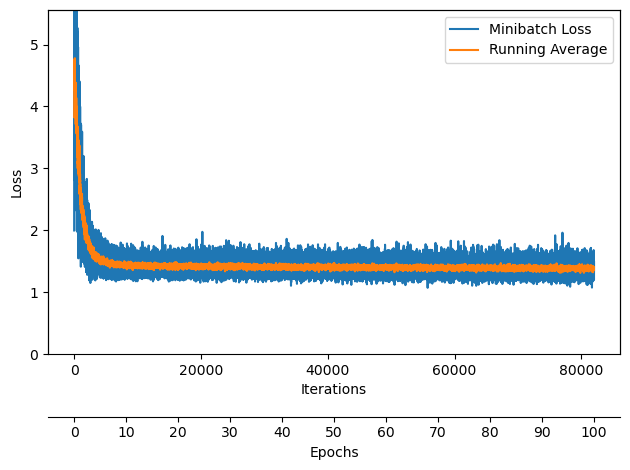

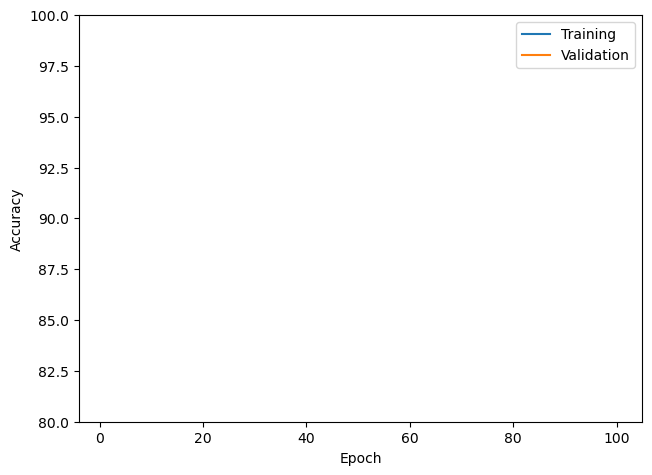

In [12]:
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=NUM_ATTRIBUTE,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             drop_proba=0.5,
                             num_classes=NUM_CLASS)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

In [13]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, NUM_ATTRIBUTE).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 39.32
Test Accuracy: 35.33


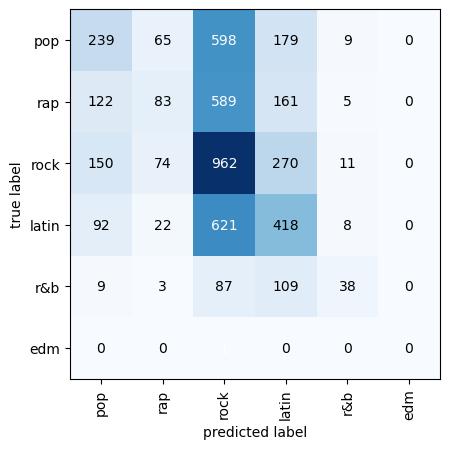

In [14]:
class_dict = {0: 'pop',
              1: 'rap',
              2: 'rock',
              3: 'latin',
              4: 'r&b',
              5: 'edm'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()